# Interpretation of Logistic Regression

In [244]:
import os

# Change the current working directory
os.chdir('/Users/robertocerina/Desktop/CSSci Semester IV/')

In [245]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

#### Let us begin from where we left off in the last workbook. Load the ANES 2020 data, focus exclusively on respondents who say they `intend to vote`. Make a binary variable to indicate voting for the Republican candidate, and set-up a few covariates (e.g. sex, age, education and ethnicity). 

#### Get the data ready for fitting a logistic regression by dropping missing values and adding a constant for the intercept. 

In [246]:
...

#### i) The `Homogeneous Probability` model:

#### Fit a logistic regression model with just an intercept, no other covariates. Plot the empirical posterior distribution of the baseline coefficients: a) on the log-odds scale; b) on the odds scale; c) on the probability scale. Interpret this result. 

In [247]:
# Fit the model 
...

Optimization terminated successfully.
         Current function value: 0.676344
         Iterations 4


In [248]:
# Get summary results
...

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6630
Model:                          Logit   Df Residuals:                     6629
Method:                           MLE   Df Model:                            0
Date:                Sun, 18 Feb 2024   Pseudo R-squ.:               5.260e-11
Time:                        16:53:17   Log-Likelihood:                -4484.2
converged:                       True   LL-Null:                       -4484.2
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3698      0.025    -14.800      0.000      -0.419      -0.321


In [249]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
...

In [250]:
# Number of simulations
...

# Simulate beta coefficients:

# on the log-odds scale
simulated_base_log_odds = ...

# on the odds scale
simulated_base_odds = np.exp(...)

# on the probability scale
simulated_base_prob = logistic_sigmoid(...)

# simulations array
simulated_base = np.stack((simulated_base_log_odds, simulated_base_odds, simulated_base_prob), axis=1)

In [251]:
print(simulated_base)

[[-0.35632826  0.70024272  0.41184868]
 [-0.35704228  0.69974291  0.41167574]
 [-0.40436853  0.66739812  0.40026321]
 ...
 [-0.38573788  0.67994873  0.40474374]
 [-0.38444881  0.6808258   0.40505435]
 [-0.30976861  0.73361669  0.42317122]]


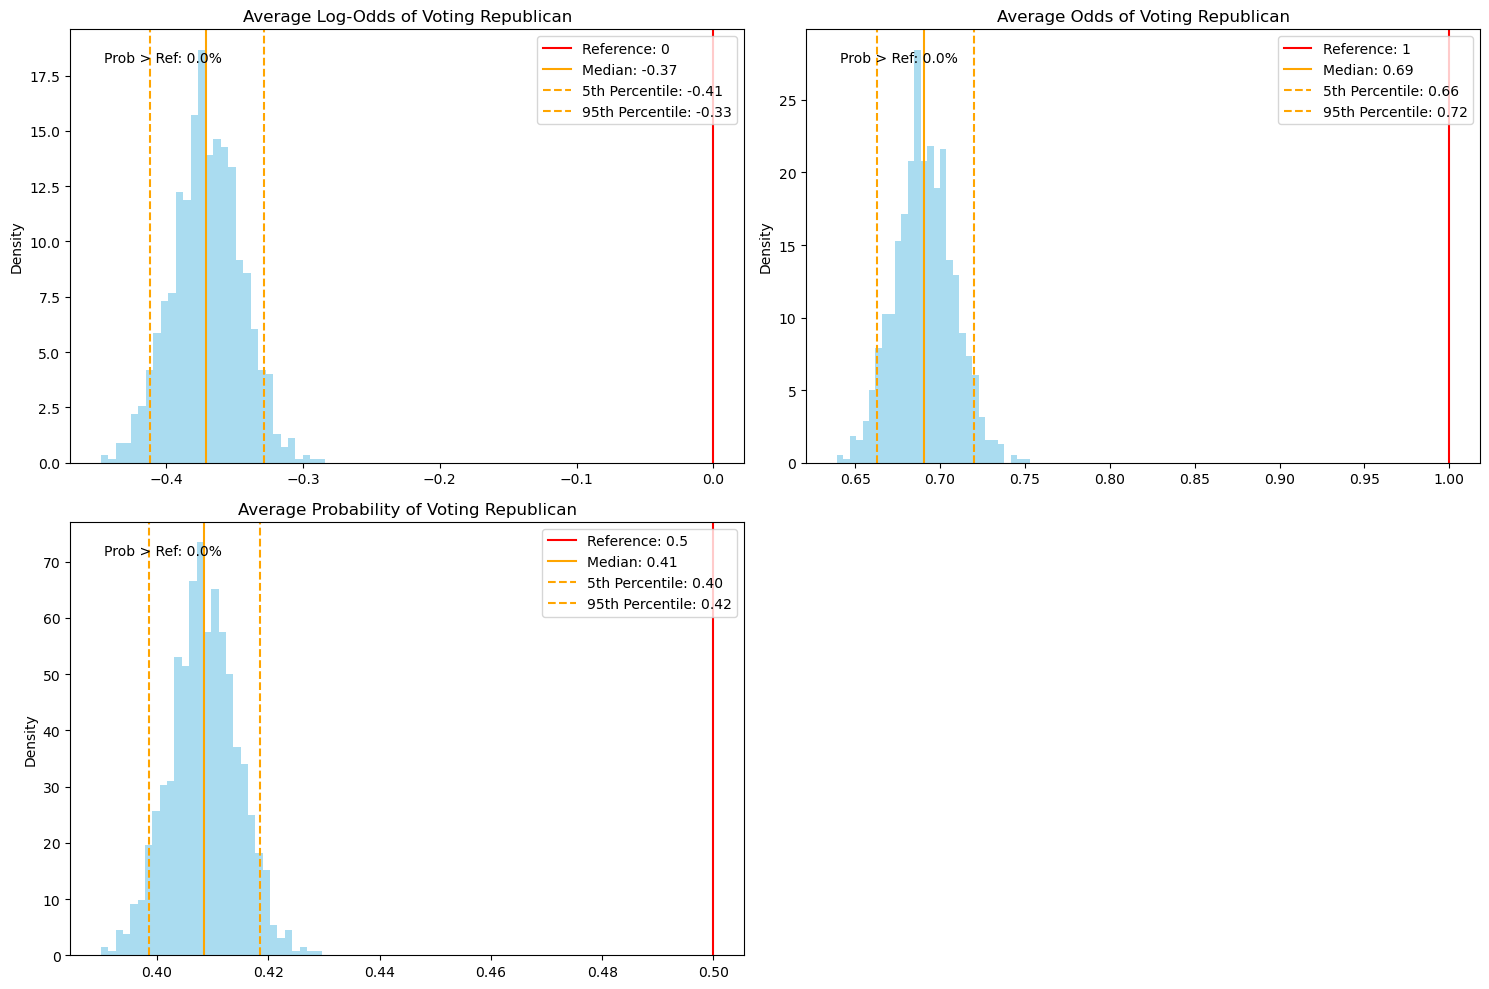

In [252]:
# Calculate statistics for each coefficient
medians = ...
lower_quantiles = ...
upper_quantiles =...
references = [0, 1, 0.5]  # Reference values for log-odds, odds, probability
prob_positive = [np.mean(simulated_base[:, i] > references[i]) for i in range(3)]

# Plot names 
col_names = ['Log-Odds', 'Odds', 'Probability']

# Plot histograms of each metric
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust for the number of metrics
axs = axs.flatten()

for i in range(len(col_names)):
    ax = axs[i]
    ax.hist(simulated_base[:, i], bins=30, density=True, alpha=0.7, color='skyblue')
    
    # Add vertical lines for reference, median, and 90% interval
    ax.axvline(references[i], color='red', linestyle='-', label=f'Reference: {references[i]}')
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    ax.text(0.05, 0.95, f'Prob > Ref: {prob_positive[i]*100:.1f}%', transform=ax.transAxes, verticalalignment='top')
    
    ax.set_title(f'Average {col_names[i]} of Voting Republican')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

# Hide empty subplot for uneven number of metrics
if len(col_names) % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()

#### Answer: 

...

#### ii) The `Heterogeneous Probability` model with one binary covariate: 

#### a) Let us build on the previous model. Firstly calculate the AIC (Akaike Information Criteria) of this homogeneous probability model - keep stock of this number, as we will use it to compare models in a few beats.

In [253]:
...

AIC: 8970.320626572073


#### b) Now let us add some complexity to our model. We want to be able to model the fact that individuals have different propensity of voting for Trump based on some of their characteristics. Much has been made of Trump's appeal to non-college educated voters. Let us introduce the dummy `College_Degree` as a covariate, fit the model and plot posterior distribution of the coefficients, on the `odds` scale.

In [254]:
# Fit the model with college education
...

Optimization terminated successfully.
         Current function value: 0.673961
         Iterations 4


In [255]:
# Get summary results
...

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6630
Model:                          Logit   Df Residuals:                     6628
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2024   Pseudo R-squ.:                0.003523
Time:                        16:53:18   Log-Likelihood:                -4468.4
converged:                       True   LL-Null:                       -4484.2
Covariance Type:            nonrobust   LLR p-value:                 1.896e-08
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.2162      0.037     -5.868      0.000      -0.288      -0.144
College_Degree    -0.2822      0.050     -5.618      0.000      -0.381      -0.184


In [256]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
...

In [257]:
# Simulate values of each regression coefficient from the posterior distirbution 
...

In [258]:
# Derive odds from log-odds coefficients 
...

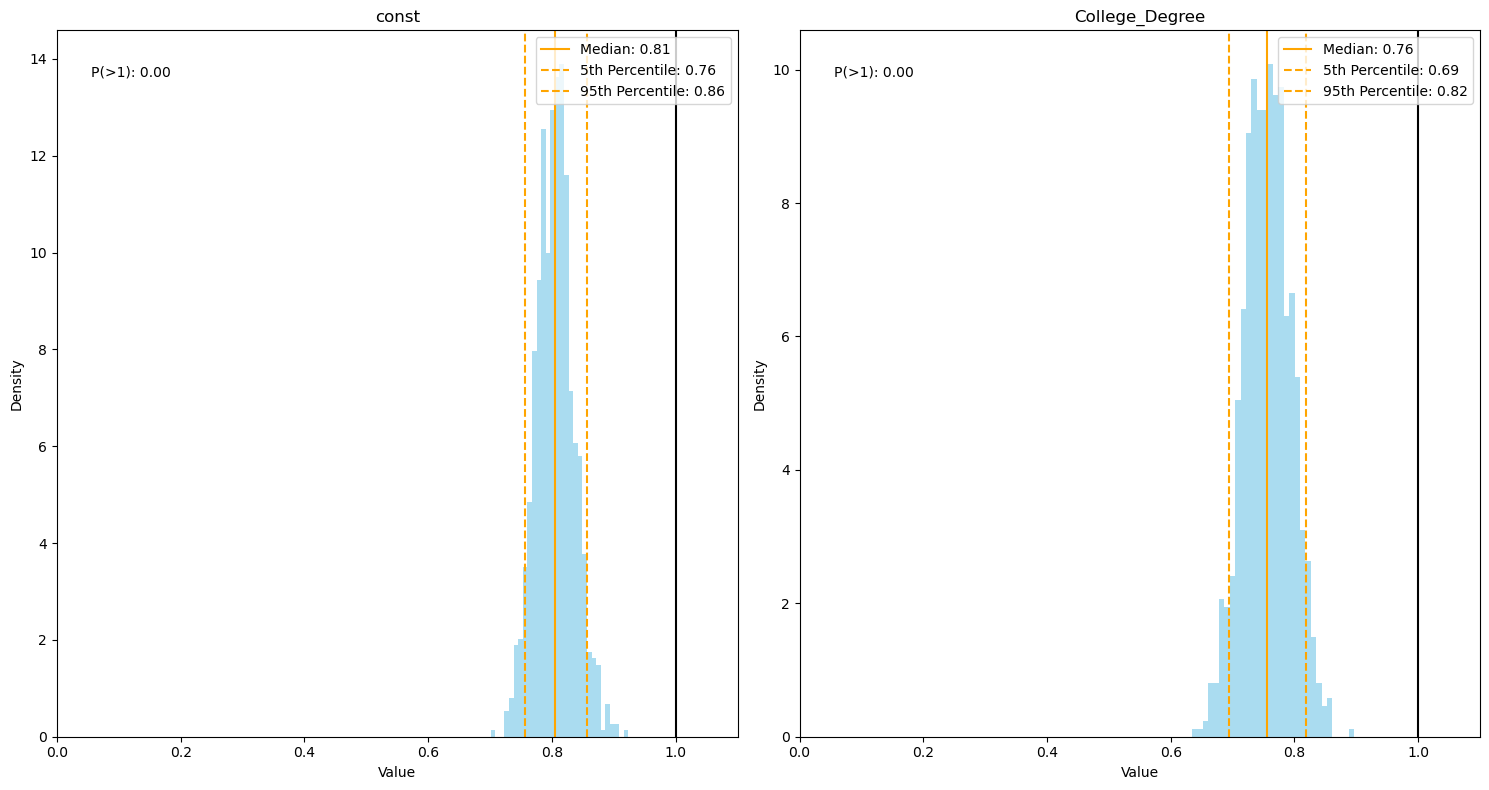

In [259]:
# Calculate statistics for each coefficient
...

# Plot names 
...

# Plot histograms of each coefficient
...

#### c) Interpret the coefficients.

#### Answer: 

...

#### d) Get the AIC of this model, and comment on its value compared to the previous model. 

In [260]:
...

AIC: 8940.722152851105


#### Answer: 

...

#### ii) The `Heterogeneous Probability` model with multiple covariates and interactions: 

#### a) Fit a logit model with education, sex, age, white-ethnicity, and and interaction between education and ethnicity 

(Tip: center and divide age by 10, so it is interpretable as a `10 year increase over the average age` as opposed to a `1 year increase over 0 years` for a 1-unit change)

In [261]:
X_with_intercept['Age'] = (X_with_intercept['Age']- ...)/...

In [262]:
X_with_intercept['NonWhite_College_Interaction'] = X['Ethnicity_NonWhite'] * X['College_Degree']

In [263]:
# Fit the model with college education
...

# Get summary results
...

Optimization terminated successfully.
         Current function value: 0.641716
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6630
Model:                          Logit   Df Residuals:                     6624
Method:                           MLE   Df Model:                            5
Date:                Sun, 18 Feb 2024   Pseudo R-squ.:                 0.05120
Time:                        16:53:20   Log-Likelihood:                -4254.6
converged:                       True   LL-Null:                       -4484.2
Covariance Type:            nonrobust   LLR p-value:                 5.171e-97
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.2841      0.052      5.477      0.000

#### b) Simulate the empirical posterior of each coefficient, and plot the histogram of each respective coefficient on the odds-scale:

In [264]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
...

In [265]:
# Simulate values of each regression coefficient from the posterior distirbution 

# Number of simulations
...
# Simulate beta coefficients
...

In [266]:
# Derive odds from log-odds coefficients 
...

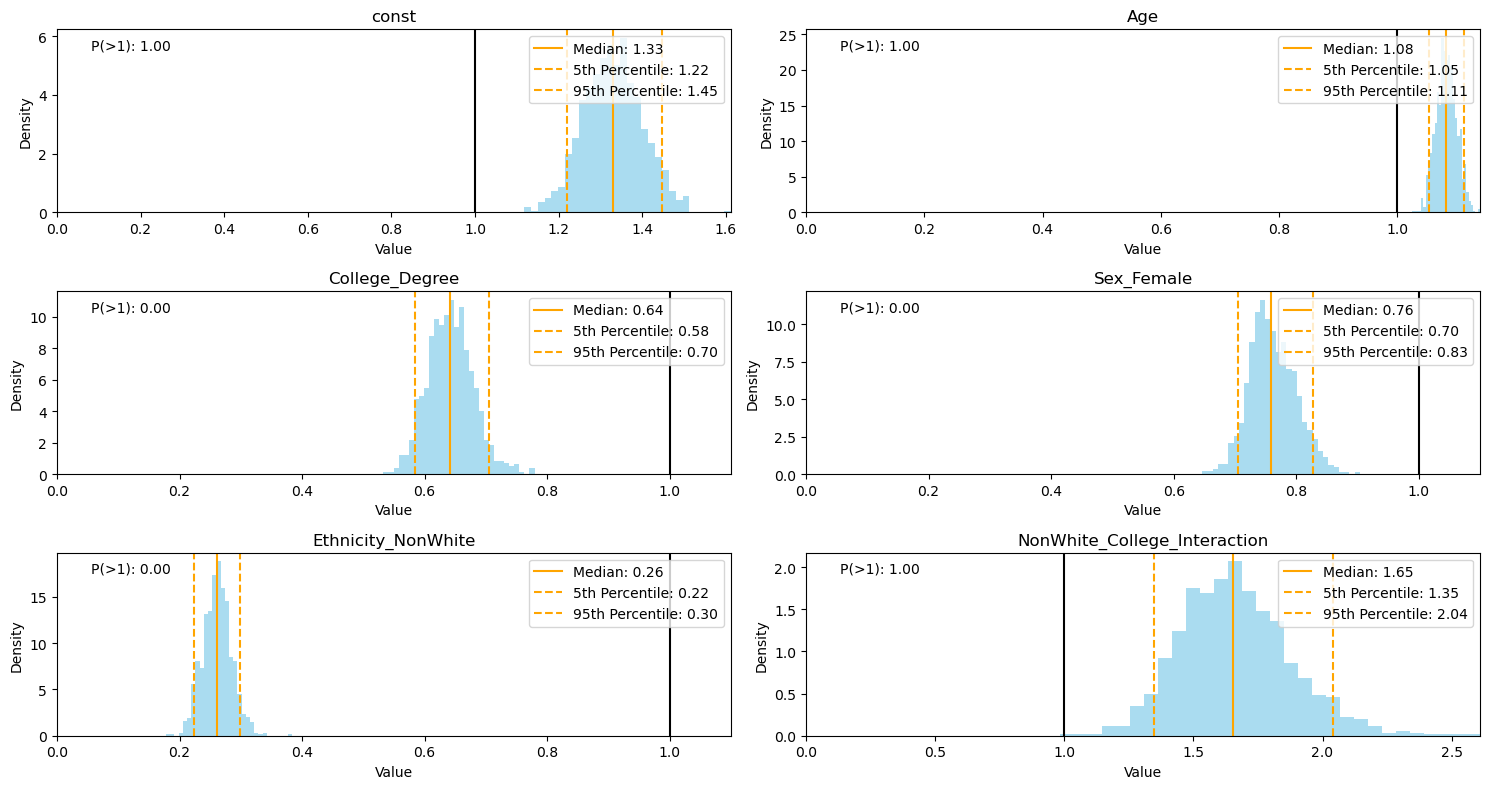

In [267]:
# Calculate statistics for each coefficient
...
# Plot names 
...
# Plot histograms of each coefficient
...

#### d) Interpret every coefficient in the model. Pay attention to `statistical significance`, and be clear about what the baseline profile over which the effects are calculated is.

#### Answer: 

...


In [1]:
# Finally, let's get the AIC of the model just to compare with what we did before. 
# Is the added complexity justified ? 
...

Ellipsis

## A final note: 

I suspect you will emerge out of this workshop thinking that odds and odds ratios are, at the very least, `tricky`. I agree with you ! Remember you always have the option of using predicted values for your inference, and calculating Relative Risk and Risk Differences between profiles of interests and reference profiles. We will explore this more in the future workshops. 